In [1]:
import pandas as pd

In [74]:
a=pd.read_csv("data2.csv")
a=a.apply(lambda L: pd.to_numeric(L, errors='coerce'))
a

,id,thickness,size,shape,adhesion,Epithelial,Nuclei,Chromatin,Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,0
1,1002945,5,4,4,5,7,10.0,3,2,1,0
2,1015425,3,1,1,1,2,2.0,3,1,1,0
3,1016277,6,8,8,1,3,4.0,3,7,1,0
4,1017023,4,1,1,3,2,1.0,3,1,1,0
5,1017122,8,10,10,8,7,10.0,9,7,1,1
6,1018099,1,1,1,1,2,10.0,3,1,1,0
7,1018561,2,1,2,1,2,1.0,3,1,1,0
8,1033078,2,1,1,1,2,1.0,1,1,5,0
9,1033078,4,2,1,1,2,1.0,2,1,1,0


In [47]:
#

In [48]:
#

In [81]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import xgboost as xgb
#from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn import metrics

#split = int(train2.shape[0]*.8)
#train = train2[0:split]
#test = pd.read_csv('../input/test.csv')


AUC = np.zeros(30)


def ginic(actual, pred):
    actual = np.asarray(actual) 
    n = len(actual)
    a_s = actual[np.argsort(pred)]
    a_c = a_s.cumsum()
    giniSum = a_c.sum() / a_s.sum() - (n + 1) / 2.0
    return giniSum / n
 
def gini_normalized(a, p):
    if p.ndim == 2:
        p = p[:,1] 
    return ginic(a, p) / ginic(a, a)


def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score
for j in range(30):
    df=a
    #df
    train, test = train_test_split(df.drop(['id'],axis=1), test_size=0.2)
    #train, test2 = train_test_split(train, test_size=0.97)
    
    
    y = train.Class.values
    y_train=train['Class']
    y_test = test['Class']
    #train.shape[0]
    id_test = test.index
    
    train = train.drop(['Class'], axis=1)
    test = test.drop(['Class'], axis=1)   
    X = train.values
    
    # Set xgb parameters
    
    
    # Create a submission file
    sub = pd.DataFrame()
    sub['id'] = id_test
    sub['target'] = np.zeros_like(id_test)
    
    params = {}
    params['objective'] = 'binary:logistic'
    params['eta'] = 0.03
    params['silent'] = False
    params['max_depth'] = 8
    params['subsample'] = 0.7
    
    kfold = 10
    sss = StratifiedShuffleSplit(n_splits=kfold, test_size=0.2)
    for i, (train_index, test_index) in enumerate(sss.split(X, y)):
        print('[Fold %d/%d]' % (i + 1, kfold))
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        print(X_train.shape)
        d_train = xgb.DMatrix(X_train, y_train)
        d_valid = xgb.DMatrix(X_valid, y_valid)
        d_test = xgb.DMatrix(test.values)
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
    
        mdl = xgb.train(params, d_train, 16000, watchlist, early_stopping_rounds=70, feval=gini_xgb, maximize=True, verbose_eval=200000)
    
        print('[Fold %d/%d Prediciton:]' % (i + 1, kfold))
        # Predict on our test data
        p_test = mdl.predict(d_test)
        sub['target'] += p_test/kfold
    
    #sub.to_csv('FattyKimJungUn.csv', index=False)
    c=gini_normalized(y_test.values, sub['target'].values)
    #c=gini_normalized(y_test.values, np.zeros(y_test.shape[0]))
    AUC[j] = (c+1)/2
    print((c+1)/2)

[Fold 1/10]
(447, 9)
[0]	train-error:0.024609	valid-error:0.035714	train-gini:0.982361	valid-gini:0.957639
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[41]	train-error:0.011186	valid-error:0.044643	train-gini:0.997343	valid-gini:0.966667

[Fold 1/10 Prediciton:]
[Fold 2/10]
(447, 9)
[0]	train-error:0.038031	valid-error:0.0625	train-gini:0.943685	valid-gini:0.955556
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[54]	train-error:0.01566	valid-error:0.044643	train-gini:0.996603	valid-gini:0.968056

[Fold 2/10 Prediciton:]
[Fold 3/10]
(447, 9)
[0]	train-error:0.033557	valid-error:0.053571	train-gini:0.978659	valid-gini:0.8875
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini has

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[26]	train-error:0.026846	valid-error:0.0625	train-gini:0.994875	valid-gini:0.984865

[Fold 2/10 Prediciton:]
[Fold 3/10]
(447, 9)
[0]	train-error:0.035794	valid-error:0.053571	train-gini:0.941633	valid-gini:0.909189
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[5]	train-error:0.026846	valid-error:0.053571	train-gini:0.995465	valid-gini:0.967568

[Fold 3/10 Prediciton:]
[Fold 4/10]
(447, 9)
[0]	train-error:0.026846	valid-error:0.053571	train-gini:0.964444	valid-gini:0.955315
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[44]	train-error:0.024609	valid-error:0.053571	train

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[34]	train-error:0.024609	valid-error:0.017857	train-gini:0.99306	valid-gini:0.998595

[Fold 3/10 Prediciton:]
[Fold 4/10]
(447, 9)
[0]	train-error:0.038031	valid-error:0.071429	train-gini:0.967274	valid-gini:0.945908
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[30]	train-error:0.017897	valid-error:0.026786	train-gini:0.993894	valid-gini:0.969793

[Fold 4/10 Prediciton:]
[Fold 5/10]
(447, 9)
[0]	train-error:0.040268	valid-error:0.071429	train-gini:0.948561	valid-gini:0.922023
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[73]	train-error:0.020134	valid-error:0.026786	train-gini:0.996662	valid-gini:0.990165

[Fold 5/10 Prediciton:]
[Fold 6/10]
(447, 9)
[0]	

Stopping. Best iteration:
[40]	train-error:0.01566	valid-error:0.035714	train-gini:0.996543	valid-gini:0.991465

[Fold 4/10 Prediciton:]
[Fold 5/10]
(447, 9)
[0]	train-error:0.044743	valid-error:0.035714	train-gini:0.956075	valid-gini:0.906828
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[163]	train-error:0.006711	valid-error:0.026786	train-gini:0.999778	valid-gini:0.984353

[Fold 5/10 Prediciton:]
[Fold 6/10]
(447, 9)
[0]	train-error:0.042506	valid-error:0.053571	train-gini:0.968618	valid-gini:0.900427
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[265]	train-error:0.008949	valid-error:0.026786	train-gini:0.999379	valid-gini:0.98862

[Fold 6/10 Prediciton:]
[Fold 7/10]
(447, 9)
[0]	train-error:0.022371	valid-error:0.026786	train-gini:0.98

Stopping. Best iteration:
[128]	train-error:0.017897	valid-error:0.035714	train-gini:0.997704	valid-gini:0.997222

[Fold 5/10 Prediciton:]
[Fold 6/10]
(447, 9)
[0]	train-error:0.03132	valid-error:0.044643	train-gini:0.98224	valid-gini:0.947222
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[18]	train-error:0.020134	valid-error:0.053571	train-gini:0.98995	valid-gini:0.974306

[Fold 6/10 Prediciton:]
[Fold 7/10]
(447, 9)
[0]	train-error:0.03132	valid-error:0.044643	train-gini:0.98159	valid-gini:0.9375
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[33]	train-error:0.026846	valid-error:0.035714	train-gini:0.995148	valid-gini:0.980556

[Fold 7/10 Prediciton:]
[Fold 8/10]
(447, 9)
[0]	train-error:0.04698	valid-error:0.044643	train-gini:0.962357	va

[Fold 6/10 Prediciton:]
[Fold 7/10]
(447, 9)
[0]	train-error:0.042506	valid-error:0.0625	train-gini:0.979393	valid-gini:0.911095
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[101]	train-error:0.017897	valid-error:0.017857	train-gini:0.997859	valid-gini:0.99431

[Fold 7/10 Prediciton:]
[Fold 8/10]
(447, 9)
[0]	train-error:0.029083	valid-error:0.0625	train-gini:0.960437	valid-gini:0.921764
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[42]	train-error:0.017897	valid-error:0.035714	train-gini:0.995986	valid-gini:0.987909

[Fold 8/10 Prediciton:]
[Fold 9/10]
(447, 9)
[0]	train-error:0.033557	valid-error:0.0625	train-gini:0.967306	valid-gini:0.939545
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will tra

[Fold 7/10 Prediciton:]
[Fold 8/10]
(447, 9)
[0]	train-error:0.038031	valid-error:0.071429	train-gini:0.965948	valid-gini:0.951712
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[2]	train-error:0.029083	valid-error:0.053571	train-gini:0.98919	valid-gini:0.982703

[Fold 8/10 Prediciton:]
[Fold 9/10]
(447, 9)
[0]	train-error:0.03132	valid-error:0.053571	train-gini:0.981262	valid-gini:0.944504
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[48]	train-error:0.01566	valid-error:0.053571	train-gini:0.998153	valid-gini:0.977658

[Fold 9/10 Prediciton:]
[Fold 10/10]
(447, 9)
[0]	train-error:0.035794	valid-error:0.044643	train-gini:0.954867	valid-gini:0.904865
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will 

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[77]	train-error:0.01566	valid-error:0.017857	train-gini:0.998188	valid-gini:0.996488

[Fold 9/10 Prediciton:]
[Fold 10/10]
(447, 9)
[0]	train-error:0.017897	valid-error:0.080357	train-gini:0.972603	valid-gini:0.944503
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[129]	train-error:0.011186	valid-error:0.044643	train-gini:0.998895	valid-gini:0.981735

[Fold 10/10 Prediciton:]
0.983527796843
[Fold 1/10]
(447, 9)
[0]	train-error:0.040268	valid-error:0.044643	train-gini:0.963502	valid-gini:0.925
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[9]	train-error:0.022371	valid-erro

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[3]	train-error:0.022371	valid-error:0.035714	train-gini:0.994394	valid-gini:0.991667

[Fold 10/10 Prediciton:]
0.979621193958
[Fold 1/10]
(447, 9)
[0]	train-error:0.042506	valid-error:0.089286	train-gini:0.948868	valid-gini:0.896159
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[37]	train-error:0.020134	valid-error:0.044643	train-gini:0.995065	valid-gini:0.980085

[Fold 1/10 Prediciton:]
[Fold 2/10]
(447, 9)
[0]	train-error:0.044743	valid-error:0.089286	train-gini:0.951403	valid-gini:0.795164
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[34]	train-error:0.008949	valid-er

Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[4]	train-error:0.020134	valid-error:0.044643	train-gini:0.993928	valid-gini:0.968388

[Fold 1/10 Prediciton:]
[Fold 2/10]
(447, 9)
[0]	train-error:0.026846	valid-error:0.080357	train-gini:0.954435	valid-gini:0.900948
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[4]	train-error:0.035794	valid-error:0.044643	train-gini:0.992066	valid-gini:0.98876

[Fold 2/10 Prediciton:]
[Fold 3/10]
(447, 9)
[0]	train-error:0.03132	valid-error:0.035714	train-gini:0.965915	valid-gini:0.950123
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[133]	train-error:0.017897	valid-error:0.035714	train

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[143]	train-error:0.011186	valid-error:0.035714	train-gini:0.999249	valid-gini:0.96347

[Fold 2/10 Prediciton:]
[Fold 3/10]
(447, 9)
[0]	train-error:0.033557	valid-error:0.044643	train-gini:0.952894	valid-gini:0.952933
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[125]	train-error:0.013423	valid-error:0.017857	train-gini:0.998144	valid-gini:0.989463

[Fold 3/10 Prediciton:]
[Fold 4/10]
(447, 9)
[0]	train-error:0.042506	valid-error:0.044643	train-gini:0.957976	valid-gini:0.98033
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[1]	train-error:0.04698	valid-error:0.017857	train-gini:0.960981	valid-gini:1

[Fold 4/10 Prediciton:]
[Fold 5/10]
(447, 9)
[0]	train-er

Stopping. Best iteration:
[150]	train-error:0.013423	valid-error:0.026786	train-gini:0.998379	valid-gini:0.995785

[Fold 3/10 Prediciton:]
[Fold 4/10]
(447, 9)
[0]	train-error:0.03132	valid-error:0.0625	train-gini:0.974289	valid-gini:0.933263
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[80]	train-error:0.022371	valid-error:0.044643	train-gini:0.996452	valid-gini:0.990868

[Fold 4/10 Prediciton:]
[Fold 5/10]
(447, 9)
[0]	train-error:0.049217	valid-error:0.0625	train-gini:0.941264	valid-gini:0.882684
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[119]	train-error:0.017897	valid-error:0.053571	train-gini:0.998204	valid-gini:0.990868

[Fold 5/10 Prediciton:]
[Fold 6/10]
(447, 9)
[0]	train-error:0.049217	valid-error:0.044643	train-gini:0.95659

Stopping. Best iteration:
[327]	train-error:0.008949	valid-error:0.035714	train-gini:0.999732	valid-gini:0.979374

[Fold 4/10 Prediciton:]
[Fold 5/10]
(447, 9)
[0]	train-error:0.035794	valid-error:0.017857	train-gini:0.956378	valid-gini:0.99431
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[0]	train-error:0.035794	valid-error:0.017857	train-gini:0.956378	valid-gini:0.99431

[Fold 5/10 Prediciton:]
[Fold 6/10]
(447, 9)
[0]	train-error:0.033557	valid-error:0.053571	train-gini:0.966325	valid-gini:0.963016
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[113]	train-error:0.017897	valid-error:0.044643	train-gini:0.997993	valid-gini:0.984353

[Fold 6/10 Prediciton:]
[Fold 7/10]
(447, 9)
[0]	train-error:0.033557	valid-error:0.035714	train-gini:0.947

Stopping. Best iteration:
[2]	train-error:0.024609	valid-error:0.035714	train-gini:0.980364	valid-gini:0.98293

[Fold 5/10 Prediciton:]
[Fold 6/10]
(447, 9)
[0]	train-error:0.042506	valid-error:0.026786	train-gini:0.951332	valid-gini:0.975818
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[2]	train-error:0.035794	valid-error:0.017857	train-gini:0.983423	valid-gini:0.997866

[Fold 6/10 Prediciton:]
[Fold 7/10]
(447, 9)
[0]	train-error:0.026846	valid-error:0.080357	train-gini:0.974824	valid-gini:0.909673
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[13]	train-error:0.022371	valid-error:0.044643	train-gini:0.995435	valid-gini:0.970128

[Fold 7/10 Prediciton:]
[Fold 8/10]
(447, 9)
[0]	train-error:0.040268	valid-error:0.0625	train-gini:0.967732	

[Fold 6/10 Prediciton:]
[Fold 7/10]
(447, 9)
[0]	train-error:0.020134	valid-error:0.071429	train-gini:0.971353	valid-gini:0.892613
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[176]	train-error:0.011186	valid-error:0.071429	train-gini:0.998784	valid-gini:0.978378

[Fold 7/10 Prediciton:]
[Fold 8/10]
(447, 9)
[0]	train-error:0.035794	valid-error:0.0625	train-gini:0.951534	valid-gini:0.922883
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 70 rounds.
Stopping. Best iteration:
[5]	train-error:0.022371	valid-error:0.044643	train-gini:0.987433	valid-gini:0.981982

[Fold 8/10 Prediciton:]
[Fold 9/10]
(447, 9)
[0]	train-error:0.038031	valid-error:0.080357	train-gini:0.956849	valid-gini:0.920721
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will

In [82]:

AUC

array([ 0.98989899,  0.99649123,  0.99767491,  0.9869926 ,  0.99040936,
        0.98921122,  0.97690065,  0.99676226,  0.9946687 ,  1.        ,
        0.98369685,  0.99515312,  0.99229947,  0.99113082,  0.9835278 ,
        0.99014536,  0.97962119,  0.99155556,  0.97986731,  0.98822464,
        0.98972902,  0.98741707,  0.99739753,  0.99431818,  0.99638803,
        0.98832342,  0.99222222,  0.98587127,  0.98484848,  0.99486631])

In [83]:
np.std(AUC)

0.0057026680774887187

In [84]:
np.mean(AUC)

0.99018711813129912

In [44]:
y_test.values

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0,
       0, 1])

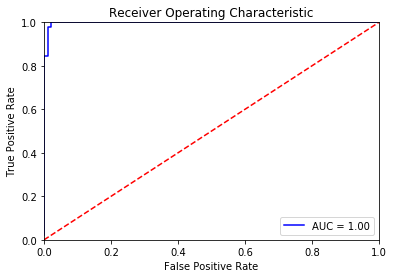

In [50]:
from sklearn import metrics

fpr, tpr, threshold = metrics.roc_curve(y_test.values, sub['target'].values)
roc_auc = metrics.auc(fpr, tpr)
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

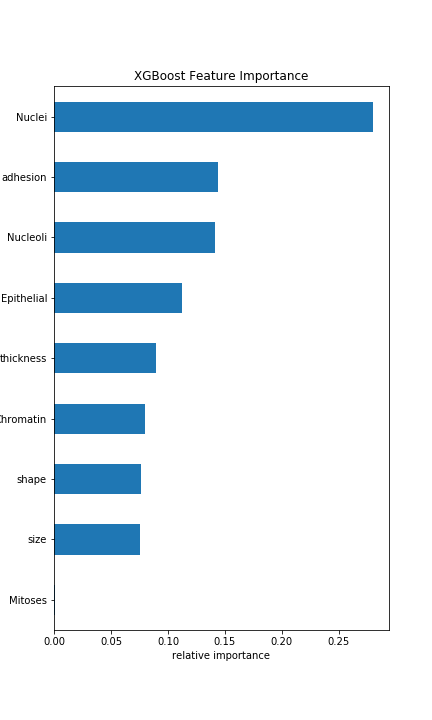

In [55]:
import operator
from matplotlib import pylab as plt
def ceate_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

train, test = train_test_split(a.drop(['id'], axis=1), test_size=0.2)



train3 = train.drop(['Class'], axis=1)

features = list(train3.columns[0:])

y_train = train['Class'].values


x_train = train3[features].values

ceate_feature_map(features)
xgb_params = {"objective": "reg:linear", "eta": 0.01, "max_depth": 8, "seed": 42, "silent": 1}
num_rounds = 10000

params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.03
params['silent'] = False
params['max_depth'] = 8
params['subsample'] = 0.9
#params['min_child_weight'] = 10
#params['colsample_bytree'] = 0.9
#params['colsample_bylevel'] = 0.9
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=features)
gbdt = xgb.train(params, dtrain, num_rounds)

importance = gbdt.get_fscore()#fmap='./xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

plt.figure()
df.plot()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')
plt.gcf().savefig('feature_importance_xgb.png')
from IPython.display import Image
Image('feature_importance_xgb.png')